## Bibliotecas

In [1]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import find

from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import math
import operator
import collections
from functools import reduce
from matplotlib import pyplot as plt

## Consulta do Usuário

In [2]:
def ConsultaUsuário(consulta):
    
    My_stopwords = set(stopwords.words('english'))
    
    # Separar a consulta por palavras.
    palavras = word_tokenize(consulta)
    # Remover as Stopwords.
    lista_Termos = [i for i in palavras if i not in My_stopwords]
    
    
    #Remover Duplicatas
    #lista_Termos = list(dict.fromkeys(lista_Termos))
    #print(lista_Termos)
    
    # Stemming para pegar termos similares atraves dos radicais das palavras.
    ps = PorterStemmer()
    lista_radicais = []
    for w in lista_Termos:
        if ps.stem(w) not in lista_radicais: 
            lista_radicais.append(ps.stem(w))
            
    return lista_Termos

In [3]:
display(ConsultaUsuário('Blue Blue'))
display(ConsultaUsuário('Black Dragon Lord'))

['Blue', 'Blue']

['Black', 'Dragon', 'Lord']

# Exemplos de Teste
* Modelo do Indice Invertido [ Termo , [ ( DOCUMENTO , TF/IDF ) ] ]
* Modelo da Consulta do Usuário: Texto qualquer

In [4]:
Docs = [
    ['Black',[('doc1',1),('doc2',2)]],
    ['dragon',[('doc2',3),('doc3',1)]],
    ['Illusion',[('doc4',1)]],
    ['lord',[('doc5',4)]]
]

consulta = r'Black Lotus of a Illusion'

## Postings

In [5]:
# Entrada para o ler_Postings = (indiceInvertido, idf)

indiceInvertido = {
                    'dragon': [('doc2',3),('doc3',1)],
                    'Illusion': [('doc4',1)],
                    'Black': [('doc1',1),('doc2',2)],
                    'lord':[('doc5',4)]
                }
idf = {
    'dragon': 0.5,
    'Illusion':0.65,
    'Black': 0.5,
    'lord':0.32
      }

In [6]:
# term at time
def ler_Postings(tupla):
    
    indiceInvertido = tupla[0]
    idf = tupla[1]
    
    # indiceInvertido = [docID , docID2 ....]
    lista = []
    for key, value in indiceInvertido.items():
        termo = key
        listaTuplas = value
        termoIDF = idf[key]
        lista.append([termo,listaTuplas,termoIDF])

       
    return lista

In [7]:
ler_Postings((indiceInvertido,idf))

[['dragon', [('doc2', 3), ('doc3', 1)], 0.5],
 ['Illusion', [('doc4', 1)], 0.65],
 ['Black', [('doc1', 1), ('doc2', 2)], 0.5],
 ['lord', [('doc5', 4)], 0.32]]

## Modelo Espaço Vetorial

### Similaridade Cosseno de Vetores

#### Document at Time

In [9]:
# Similaridade Cosseno
def SimilaridadeCosseno(vetorQuery,vetorDoc):
    score = np.dot(vetorQuery,vetorDoc) / (math.sqrt((np.dot(vetorQuery,vetorQuery))*(np.dot(vetorDoc,vetorDoc))))
    return score

### Matrix de Vetores
* <strong>Sem TF/IDF</strong> 
    Apenas a presença do termo no documento.

In [10]:
def MatrixVetores(Postings,query):
    
    # Lista com os termos tanto dos postings quanto da consulta.
    termosVocabulario = []
    
    # Add consulta(query) e os documentos.
    documentoNomes = [query]
    
    # Add termos da consulta ao vocabulario.
    for termos in ConsultaUsuário(query):
        if termos not in termosVocabulario:
            termosVocabulario.append(termos)
    
    # Add os termos dos documentos dos postings ao vocabulario.
    for posting in Postings:
        if posting[0] not in termosVocabulario:
            termosVocabulario.append(posting[0])
        for tupla in posting[1]:
            if tupla[0] not in documentoNomes:
                documentoNomes.append(tupla[0])
    
    #print('termos do Vocabulario (Query e Documentos): ',termosVocabulario,"\n\n")
    #print('Nome dos Documentos (Query e Documentos): ',documentoNomes,"\n\n")
    
    # Criando matrix de vetores 
    matrixVazia = np.zeros((len(termosVocabulario),len(documentoNomes)),dtype=object)
    
    # Add nomes as rows e columns (rows = termos e columns docs)
    df = pd.DataFrame(matrixVazia, columns=documentoNomes, index=termosVocabulario)
    
    # Inserir os valores na matrix (sem tf/idf) se existe 1 se não 0
    nameColumns = list(df.columns)
    nameRows = list(df.index)
     
    # Preenchendo os valores dos vetores usando Document-at-time.
    for doc in nameColumns:
        for termo in nameRows:
            
            # Verificando a query.
            if termo in ConsultaUsuário(query) and doc == query:
                df.loc[termo,doc] = 1
            else:
                df.loc[termo,doc] = 0
     
            # Verificando os docs.
            for posting in Postings:
                if termo == posting[0]:
                    for tupla in posting[1]:
                        if doc == tupla[0]:
                            if tupla[1] > 0:
                                df.loc[termo,doc] = 1
                            else:
                                df.loc[termo,doc] = 0
      
    
    df.rename(columns={query:'Query'},inplace = True)    
    #display(df)
    return df
print('Exemplo: consulta = Black Lotus of a Illusion')
MatrixVetores(ler_Postings((indiceInvertido,idf)),consulta)

Exemplo: consulta = Black Lotus of a Illusion


,Query,doc2,doc3,doc4,doc1,doc5
Black,1,1,0,0,1,0
Lotus,1,0,0,0,0,0
Illusion,1,0,0,1,0,0
dragon,0,1,1,0,0,0
lord,0,0,0,0,0,1


### Matrix de Vetores
* <strong>TF/IDF</strong> 

In [11]:
def MatrixVetores_TF_IDF(Postings,query):
    
    # Lista com os termos tanto dos postings quanto da consulta.
    termosVocabulario = []
    
    # Add consulta(query) e os documentos.
    documentoNomes = [query]
    
    # Add termos da consulta ao vocabulario.
    for termos in ConsultaUsuário(query):
        if termos not in termosVocabulario:
            termosVocabulario.append(termos)
    
    # Add os termos dos documentos dos postings ao vocabulario.
    for posting in Postings:
        if posting[0] not in termosVocabulario:
            termosVocabulario.append(posting[0])
        for tupla in posting[1]:
            if tupla[0] not in documentoNomes:
                documentoNomes.append(tupla[0])
    
    #print('termos do Vocabulario (Query e Documentos): ',termosVocabulario,"\n\n")
    #print('Nome dos Documentos (Query e Documentos): ',documentoNomes,"\n\n")
    
    # Criando matrix de vetores 
    matrixVazia = np.zeros((len(termosVocabulario),len(documentoNomes)),dtype=object)
    
    # Add nomes as rows e columns (rows = termos e columns docs)
    df = pd.DataFrame(matrixVazia, columns=documentoNomes, index=termosVocabulario)
    
    # Inserir os valores na matrix (sem tf/idf) se existe 1 se não 0
    nameColumns = list(df.columns)
    nameRows = list(df.index)
     
    # Preenchendo os valores dos vetores.
    for doc in nameColumns:
        for termo in nameRows:
            
            # Verificando a query.
            if termo in ConsultaUsuário(query) and doc == query:
                # TF do termo na query
                TF = ConsultaUsuário(query).count(termo)
                
                IDF = TF
                ## IDF do termo.
                for posting in Postings:
                    if termo == posting[0]:
                        IDF = posting[2]
                
                #TF_idf = Consulta_TF_IDF(query,termo)
                #print(termo,TF,IDF)
                df.loc[termo,doc] = TF / IDF
            else:
                df.loc[termo,doc] = 0
     
            # Verificando os docs.
            for posting in Postings:
                if termo == posting[0]:
                    for tupla in posting[1]:
                        if doc == tupla[0]:
                            if tupla[1] > 0:
                                # valor do 2 componente da tupla [termo , [ ( doc, TF ) ] , IDF ]
                                df.loc[termo,doc] = tupla[1] / posting[2]
                            else:
                                df.loc[termo,doc] = 0      
    
    df.rename(columns={query:'Query'},inplace = True)    
    #display(df)
    return df
print('Exemplo: consulta = Black Lotus of a Illusion')
MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),consulta)

Exemplo: consulta = Black Lotus of a Illusion


,Query,doc2,doc3,doc4,doc1,doc5
Black,2,4,0,0,2,0
Lotus,1,0,0,0,0,0
Illusion,1.53846,0,0,1.53846,0,0
dragon,0,6,2,0,0,0
lord,0,0,0,0,0,12.5


### Resposta Consulta 
    *Lista de Documentos Ordenada pela similaridade dos cossenos (Documento e Query)

In [12]:
def RespostaConsulta(matrixVetores):
    # Lista de cocumentos e seus scores (doc,score)
    ListaDocumentos = []
    
    # Pegando o vetorQuery
    vetorQuery = matrixVetores['Query'].to_numpy()
    
    for col in matrixVetores.columns:  
        # Score da Similaridade de cossenos
        score = SimilaridadeCosseno(vetorQuery,matrixVetores[col].to_numpy())
        
        # documento comparado a query
        documento = col

        ListaDocumentos.append((documento,score))
    # Ordenar pelo Score.
    ListaDocumentos.sort(key=operator.itemgetter(1),reverse=True)
    
    return ListaDocumentos

In [78]:
def info_Doc(listaDocumentos):
    ordemDocumentos = []
    for tupla in listaDocumentos:
        if tupla[0] != 'Query':
            ordemDocumentos.append(tupla[0])
    print(ordemDocumentos)
    
    #teste = 'https://abugames.com/magic-the-gathering/singles'
    infoData = pd.read_csv('final_cards.csv')
    display(infoData)
    
    return None

In [79]:
info_Doc(RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),consulta)))

['doc4', 'doc1', 'doc2', 'doc3', 'doc5']


,Unnamed: 0,Unnamed: 0.1,desc,mana,name,price,rarity,type,url
0,0,0,Look at the top seven cards of your library. P...,2uu,Core Set 2020 Foil: Drawn from Dreams,$3.49,Rare,Sorcery,https://www.cardkingdom.com/mtg/core-set-2020/...
1,1,1,Sacrifice a land: You gain 3 life.\r\nThe deca...,bgw,Overgrown Estate,$0.35,Rare,Enchantment,https://abugames.com/magic-the-gathering/singl...
2,2,2,"As Arsenal Thresher comes into play, you may r...",2w/bu,Arsenal Thresher,$0.01,NaN,Artifact Creature - Construct,https://www.mtgotraders.com/store/ARB_Arsenal_...
3,3,3,Target creature gains deathtouch until end of ...,1b,Bladebrand,$0.02,NaN,Instant,https://www.mtgotraders.com/store/M20_Bladebra...
4,4,4,Flying T Add one mana of any color to your man...,g,Birds of Paradise - Foil,NaN,Rare,Creature - Bird,https://www.capefeargames.com/catalog/magic_si...
5,5,5,Any creature in either player's graveyard come...,1b,Animate Dead,$419.99,Uncommon,Enchantment - Aura,https://abugames.com/magic-the-gathering/singl...
6,6,6,+2: During target opponent's next turn creatur...,3ww,Gideon Jura - Foil,$14.20,Mythic,Planeswalker - Gideon,https://www.capefeargames.com/catalog/magic_si...
7,7,7,Whenever a permanent an opponent controls is p...,4ubbr,Prince of Thralls,$0.02,NaN,Creature - Demon,https://www.mtgotraders.com/store/ALA_Prince_o...
8,8,8,Argothian Enchantress can't be the target of s...,1g,Argothian Enchantress (Judge),$39.99,Promo,Creature,http://www.starcitygames.com/catalog/magic_the...
9,9,9,Tap: Target creature an opponent controls atta...,1u,Alluring Siren,$0.25,Uncommon,Creature,http://www.starcitygames.com/catalog/magic_the...


## Resposta usando MatrixVetores sem TF/IDF

In [13]:
print('Exemplo: consulta = Black Lotus of a Illusion')
RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),consulta))

Exemplo: consulta = Black Lotus of a Illusion


[('Query', 1.0),
 ('doc4', 0.5773502691896258),
 ('doc1', 0.5773502691896258),
 ('doc2', 0.4082482904638631),
 ('doc3', 0.0),
 ('doc5', 0.0)]

In [14]:
print('Exemplo: consulta = Blue and Red dragon') 
RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Blue and Red dragon'))

Exemplo: consulta = Blue and Red dragon


[('Query', 1.0),
 ('doc3', 0.5773502691896258),
 ('doc2', 0.4082482904638631),
 ('doc4', 0.0),
 ('doc1', 0.0),
 ('doc5', 0.0)]

## Resposta usando MatrixVetores com TF/IDF

In [15]:
print('Exemplo: consulta = Black Lotus of a Illusion')
RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),consulta))

Exemplo: consulta = Black Lotus of a Illusion


[('Query', 1.0),
 ('doc1', 0.7368662616446765),
 ('doc4', 0.5668202012651357),
 ('doc2', 0.40873985992605305),
 ('doc3', 0.0),
 ('doc5', 0.0)]

In [16]:
print('Exemplo: consulta = Blue and Red dragon')
RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Blue and Red dragon'))

Exemplo: consulta = Blue and Red dragon


[('Query', 1.0),
 ('doc3', 0.8164965809277261),
 ('doc2', 0.6793662204867574),
 ('doc4', 0.0),
 ('doc1', 0.0),
 ('doc5', 0.0)]

# Correlação de Spearman

In [17]:
# Correlação de Spearman
def Correlação_Spearman(consultasRepostas):
    
    # Removendo indice de query
    for listaconsulta in consultasRepostas:
        for tupla in listaconsulta:
            if tupla[0] == 'Query':
                listaconsulta.remove(tupla)
    
    # tamanho da matrix
    numeroColunas = len(consultasRepostas[0])
    numeroLinhas = len(consultasRepostas)
    
    colunaNomes = []
    linhaNomes = []
    dicionariolinhas = {}
    count = 0
    # Definindo os nomes da matrix
    for lista in consultasRepostas:
        # Nomes das colunas
        for tupla in lista:
            if tupla[0] not in colunaNomes:
                colunaNomes.append(tupla[0])
        
        # Nome das linhas
        count = count + 1
        nomelista = 'Consulta ' + str(count)
        linhaNomes.append(nomelista)
        dicionariolinhas[nomelista] = lista
    
    # matrixVazia
    matrixVazia = np.zeros((numeroLinhas,numeroColunas),dtype=object)
    # Add nomes as rows e columns
    df = pd.DataFrame(matrixVazia, columns=colunaNomes, index=linhaNomes)
    
    matrixColunas = list(df.columns)
    matrixLinhas = list(df.index)
     
    # Preenchendo os valores dos vetores.
    for linha in matrixLinhas: 
        for coluna in matrixColunas: 
            
            for lista in consultasRepostas:
                if dicionariolinhas[linha] == lista:
                    for tupla in lista:
                        if coluna == tupla[0]:
                            df.loc[linha,coluna] = tupla[1]
    
    print('########## Tabela Score Similaridade Cosseno (consultas x Documentos) ########## ','\n')

    display(df)
    print('########## Ranking Consultas ##########','\n')
    
    for coluna in matrixColunas:
        df[coluna] = df[coluna].astype('float64')
    

    dicionarioRankings = {}
    
        
    for linha in matrixLinhas:
        auxDF = df.copy()
        countMax = 1
        listaTuplas = []
        
        for coluna in matrixColunas:
            
            colunaValorMaximo = auxDF.loc[linha].idxmax(axis = 1,skipna = True)

            #print(auxDF.loc[linha,colunaValorMaximo])

            Ranking = countMax
            
            Tupla = (colunaValorMaximo,Ranking)
            
            if Tupla not in listaTuplas:
                listaTuplas.append(Tupla)
            
            dicionarioRankings[linha] = listaTuplas
            
            countMax = countMax + 1
            
            auxDF.drop(colunaValorMaximo,axis=1,inplace=True)
        
    print('Dicionario Rankings: ',dicionarioRankings,'\n')        
    
    listaDicionariosRankings = []
    for linha in matrixLinhas:
        listaDicionariosRankings.append(dict(dicionarioRankings[linha]))
        
    #print('To aqui! ' , listaDicionariosRankings,'\n')
    
    print('########## Rankings ##########','\n')

        # [   [('doc4', 1), ('doc1', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)],
        #     [('doc4', 1), ('doc3', 2), ('doc5', 3), ('doc2', 4), ('doc1', 5)]   ]
    # Rankings

    Rankings = []
    
    for elem in listaDicionariosRankings:
        
        # Primeiro ordernar dicionario pela chave
        h0 = dict(collections.OrderedDict(sorted(elem.items())))
        
        h = list(h0.values())
        Rankings.append(h)
    
                
    print('Rankings: ', Rankings,'\n')
    
    print('########## Diferença dos Rankings (Ranking 1 - Ranking 2) ##########','\n')

    # diferença dos rankings
    diferencaRankings = []
    for nome in colunaNomes:
        t = [d[nome] for d in listaDicionariosRankings if nome in d]
        diferencaRankings.append(reduce(operator.sub, t))

    print('Diferença entre os Rankings: ',diferencaRankings , '\n')
    
    print('########## Quadrado da Diferença ##########','\n')

    # Quadrado da diferença entre os Rankings
    diferencaRankingsQuadrado = [i ** 2 for i in diferencaRankings]
    print('Lista - Quadrado da diferença entre os Rankings: ',diferencaRankingsQuadrado,'\n')
    
    
    print('########## Somátorio(diferença^2) ##########','\n')

    # Somatorio dos quadrados da diferença
    somatorio = sum(diferencaRankingsQuadrado)
    print('Somatorio: ', somatorio , '\n')
    
    print('########## Coeficiente Spearman ##########','\n')
    
    n = len(diferencaRankingsQuadrado)
    
    # Coeficiente spearman
    cs = 1 - ((6*somatorio) / (n * ((n**2) - 1)))  
    print('Coeficiente de Spearman: ',cs,'\n')
    
    print('########## GRafico Dispersão ##########','\n')
    
    x = Rankings[0]
    y = Rankings[1]
    plt.scatter(x,y, label= "Pontos", color= "black",s=50)
    # naming the x axis 
    plt.xlabel('Ranking 1 | Consulta 1') 
    # naming the y axis 
    plt.ylabel('Ranking 2 | Consulta 2')
    plt.title('Correlação de Spearman') 
    # showing legend 
    plt.legend() 
 
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')
      
    return plt.show()

## Coeficiente da Correlação de Spearman 
* consulta -> <strong>Black Lotus of a Illusion</strong>
* consulta -> <strong>Test a Illusion of a black dragon lord</strong>

## Sem TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc4,doc1,doc2,doc3,doc5
Consulta 1,0.57735,0.57735,0.408248,0,0
Consulta 2,0.447214,0,0.316228,0.447214,0.447214


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc4', 1), ('doc1', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc4', 1), ('doc3', 2), ('doc5', 3), ('doc2', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[2, 3, 4, 1, 5], [5, 4, 2, 1, 3]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [0, -3, -1, 2, 2] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [0, 9, 1, 4, 4] 

########## Somátorio(diferença^2) ########## 

Somatorio:  18 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  0.09999999999999998 

########## GRafico Dispersão ########## 



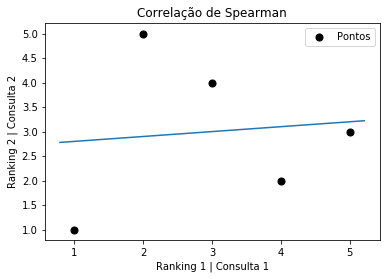

In [31]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),consulta)),
                            RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Test a Illusion of a black dragon lord'))]
Correlação_Spearman(listadeRespostasConsulta)

## Com TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc1,doc4,doc2,doc3,doc5
Consulta 1,0.736866,0.56682,0.40874,0,0
Consulta 2,0,0.361292,0.390797,0.469679,0.733874


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc5', 1), ('doc3', 2), ('doc2', 3), ('doc4', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[1, 3, 4, 2, 5], [5, 3, 2, 4, 1]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [-4, -2, 0, 2, 4] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [16, 4, 0, 4, 16] 

########## Somátorio(diferença^2) ########## 

Somatorio:  40 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  -1.0 

########## GRafico Dispersão ########## 



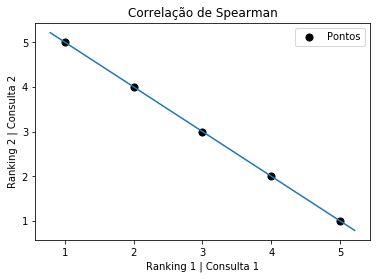

In [30]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),consulta)),
                            RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Test a Illusion of a black dragon lord'))]
Correlação_Spearman(listadeRespostasConsulta)

# Testando Correlação de Spearman
* consulta 1 = <strong>Black Lotus of a Illusion</strong>
* consulta 2 = <strong>Test a Illusion of a black dragon lord</strong>
* consulta 3 = <strong>lord dragon</strong>
* consulta 4 = <strong>Red dragon</strong>
* consulta 5 = <strong>Illusion of a black lord</strong>

### consulta 3 e 2

## Sem TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc3,doc5,doc2,doc4,doc1
Consulta 1,0.707107,0.707107,0.5,0,0
Consulta 2,0.447214,0.447214,0.316228,0.447214,0


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc3', 1), ('doc5', 2), ('doc2', 3), ('doc4', 4), ('doc1', 5)], 'Consulta 2': [('doc3', 1), ('doc5', 2), ('doc4', 3), ('doc2', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[5, 3, 1, 4, 2], [5, 4, 1, 3, 2]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [0, 0, -1, 1, 0] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [0, 0, 1, 1, 0] 

########## Somátorio(diferença^2) ########## 

Somatorio:  2 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  0.9 

########## GRafico Dispersão ########## 



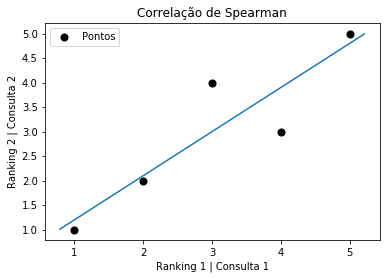

In [28]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'lord dragon')),
                            RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Test a Illusion of a black dragon lord'))]
Correlação_Spearman(listadeRespostasConsulta)

## Com TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc5,doc3,doc2,doc4,doc1
Consulta 1,0.842271,0.539054,0.44852,0,0
Consulta 2,0.733874,0.469679,0.390797,0.361292,0


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc5', 1), ('doc3', 2), ('doc2', 3), ('doc4', 4), ('doc1', 5)], 'Consulta 2': [('doc5', 1), ('doc3', 2), ('doc2', 3), ('doc4', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[5, 3, 2, 4, 1], [5, 3, 2, 4, 1]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [0, 0, 0, 0, 0] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [0, 0, 0, 0, 0] 

########## Somátorio(diferença^2) ########## 

Somatorio:  0 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  1.0 

########## GRafico Dispersão ########## 



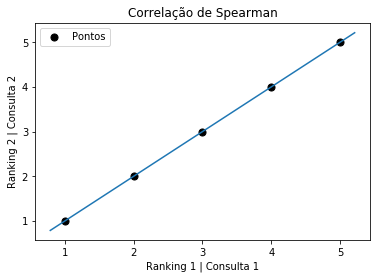

In [29]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'lord dragon')),
                            RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Test a Illusion of a black dragon lord'))]
Correlação_Spearman(listadeRespostasConsulta)

### consulta 1 e 3

## Sem TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc4,doc1,doc2,doc3,doc5
Consulta 1,0.57735,0.57735,0.408248,0,0
Consulta 2,0,0,0.5,0.707107,0.707107


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc4', 1), ('doc1', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc3', 1), ('doc5', 2), ('doc2', 3), ('doc4', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[2, 3, 4, 1, 5], [5, 3, 1, 4, 2]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [-3, -3, 0, 3, 3] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [9, 9, 0, 9, 9] 

########## Somátorio(diferença^2) ########## 

Somatorio:  36 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  -0.8 

########## GRafico Dispersão ########## 



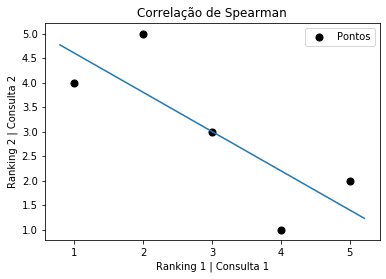

In [20]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),consulta)),
                            RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'lord dragon'))]
Correlação_Spearman(listadeRespostasConsulta)

## Com TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc1,doc4,doc2,doc3,doc5
Consulta 1,0.736866,0.56682,0.40874,0,0
Consulta 2,0,0,0.44852,0.539054,0.842271


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc5', 1), ('doc3', 2), ('doc2', 3), ('doc1', 4), ('doc4', 5)]} 

########## Rankings ########## 

Rankings:  [[1, 3, 4, 2, 5], [4, 3, 2, 5, 1]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [-3, -3, 0, 2, 4] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [9, 9, 0, 4, 16] 

########## Somátorio(diferença^2) ########## 

Somatorio:  38 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  -0.8999999999999999 

########## GRafico Dispersão ########## 



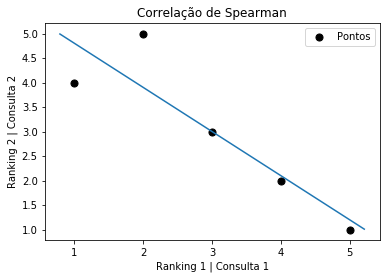

In [27]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),consulta)),
                            RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'lord dragon'))]
Correlação_Spearman(listadeRespostasConsulta)

### consulta 5 e 4

## Sem TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc4,doc5,doc2,doc3,doc1
Consulta 1,0.57735,0.57735,0,0,0
Consulta 2,0,0,0.5,0.707107,0


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc4', 1), ('doc5', 2), ('doc2', 3), ('doc3', 4), ('doc1', 5)], 'Consulta 2': [('doc3', 1), ('doc2', 2), ('doc4', 3), ('doc5', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[5, 3, 4, 1, 2], [5, 2, 1, 3, 4]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [-2, -2, 1, 3, 0] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [4, 4, 1, 9, 0] 

########## Somátorio(diferença^2) ########## 

Somatorio:  18 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  0.09999999999999998 

########## GRafico Dispersão ########## 



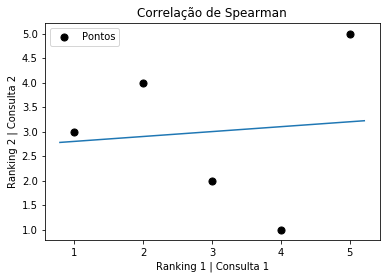

In [21]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Illusion of a black lord')),
                            RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Red dragon'))]
Correlação_Spearman(listadeRespostasConsulta)

## Com TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc5,doc4,doc2,doc3,doc1
Consulta 1,0.862336,0.424535,0,0,0
Consulta 2,0,0,0.744208,0.894427,0


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc5', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc1', 5)], 'Consulta 2': [('doc3', 1), ('doc2', 2), ('doc5', 3), ('doc4', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[5, 3, 4, 2, 1], [5, 2, 1, 4, 3]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [-2, -2, 1, 3, 0] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [4, 4, 1, 9, 0] 

########## Somátorio(diferença^2) ########## 

Somatorio:  18 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  0.09999999999999998 

########## GRafico Dispersão ########## 



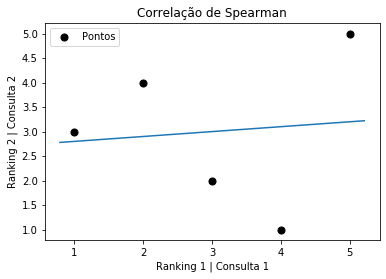

In [26]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Illusion of a black lord')),
                            RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Red dragon'))]
Correlação_Spearman(listadeRespostasConsulta)

### consulta 2 e 5

## Sem TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc3,doc4,doc5,doc2,doc1
Consulta 1,0.447214,0.447214,0.447214,0.316228,0
Consulta 2,0,0.57735,0.57735,0,0


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc3', 1), ('doc4', 2), ('doc5', 3), ('doc2', 4), ('doc1', 5)], 'Consulta 2': [('doc4', 1), ('doc5', 2), ('doc3', 3), ('doc2', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[5, 4, 1, 2, 3], [5, 4, 3, 1, 2]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [-2, 1, 1, 0, 0] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [4, 1, 1, 0, 0] 

########## Somátorio(diferença^2) ########## 

Somatorio:  6 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  0.7 

########## GRafico Dispersão ########## 



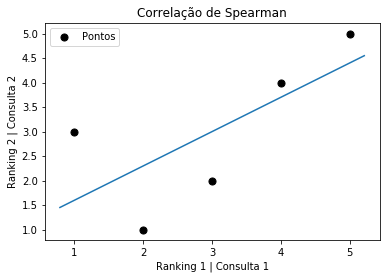

In [25]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Test a Illusion of a black dragon lord')),
                            RespostaConsulta(MatrixVetores(ler_Postings((indiceInvertido,idf)),'Illusion of a black lord'))]
Correlação_Spearman(listadeRespostasConsulta)

## Com TF/IDF

########## Tabela Score Similaridade Cosseno (consultas x Documentos) ##########  



,doc5,doc3,doc2,doc4,doc1
Consulta 1,0.733874,0.469679,0.390797,0.361292,0
Consulta 2,0.862336,0,0,0.424535,0


########## Ranking Consultas ########## 

Dicionario Rankings:  {'Consulta 1': [('doc5', 1), ('doc3', 2), ('doc2', 3), ('doc4', 4), ('doc1', 5)], 'Consulta 2': [('doc5', 1), ('doc4', 2), ('doc3', 3), ('doc2', 4), ('doc1', 5)]} 

########## Rankings ########## 

Rankings:  [[5, 3, 2, 4, 1], [5, 4, 3, 2, 1]] 

########## Diferença dos Rankings (Ranking 1 - Ranking 2) ########## 

Diferença entre os Rankings:  [0, -1, -1, 2, 0] 

########## Quadrado da Diferença ########## 

Lista - Quadrado da diferença entre os Rankings:  [0, 1, 1, 4, 0] 

########## Somátorio(diferença^2) ########## 

Somatorio:  6 

########## Coeficiente Spearman ########## 

Coeficiente de Spearman:  0.7 

########## GRafico Dispersão ########## 



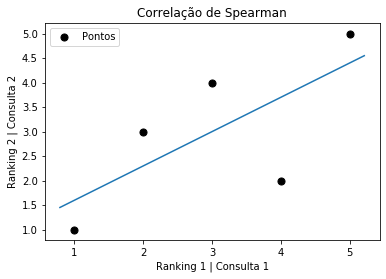

In [24]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Test a Illusion of a black dragon lord')),
                            RespostaConsulta(MatrixVetores_TF_IDF(ler_Postings((indiceInvertido,idf)),'Illusion of a black lord'))]
Correlação_Spearman(listadeRespostasConsulta)